In [2]:
import numpy as np
from scipy.integrate import odeint
import sympy as sy
import matplotlib.pyplot as plt

## Leito Fixo Bifásico COM Efeitos Difusivos

### Dados

In [135]:
## CINÉTICA
# C10H8 + 4.5 02 --K1--> C8H4O2 + 2 CO2 + 2 H20
# deltaH (630 K) = -429 kcal/mol
# k1 = 5.74e13 * exp(-38000/RT) s^-1

## CATALISADOR V2O5
# Esférico
dp = 0.318e-2 #m
Sa = 80 #m2/g
Eb = 0.4
roP = 1.4  # g/cm3

## REATOR
# 0.75% Naftaleno
# T < 673 K
# deltaP < 1 atm
# 1000 tubos, aço inovxidável 2in Sch40 (At = 2.165e-3 m2, d = 5.25e-2 m)
At = 2.165e-3 #m2
P0 = 1.7 #atm
T0 = 630 #K

## MISTURA REACIONAL
# Cpmédio(630 K) = 0.255 cal/g.K
# Mi mistura (cte) = 320e-6 Poise
visc = 320e-6 / 10 # kg / m s
# U = 1e-3 cal/s.cm2.K
#Dab = 0.068 cm2/s
Dab = 0.068/10000 #m2/s
Def = 1.41/10000 #m2/s
FA0_lb = 6e6 #lb/ano
M_naftaleno = 128. # g/mol
FA0_1000 = FA0_lb / 365 / 24 / 3600 / 2.20462 * 1000 /128 # gmol/s para os 1000 tubos
FA0 = FA0_1000 / 1000
ya0_naftaleno = 0.0075
FT0 = FA0 * (1 - ya0_naftaleno) / ya0_naftaleno
Mmed = ya0_naftaleno * 128 + (1 - ya0_naftaleno) * 0.21 * 32 + (1 - ya0_naftaleno) * 0.79 * 28

## CÁLCULOS PRELIMINARES
roB = (roP * 1000) * (1 - Eb)
print("Massa específica do leito: {} kgP / m3 leito".format(roB))

Massa específica do leito: 840.0 kgP / m3 leito


### Passo 1) Verificar Efeito Difusivo Intrapartícula
Professora utilizou R = 2 cal/mol.K

Professora errou valor de roP no cálculo de K2linha (usou 8.4e2 correto é 1.4e3 mas em thiele usou outro)

Isso muda todo o exercício.

In [141]:
print("Estimar sempre na entrada pois concentração máxima.\nMais provável ponto que etapa difusiva seja a mais lenta\n")
Kdada = 5.74e13 * np.exp(-38000 / (2 * T0))
print("Kdada: {:.2f} s^-1".format(Kdada))

K2linha = Kdada * Eb / ((roP * 1000) * (Sa * 1000))
print("K2linha: {:e} m3r / (m2p . s)".format(K2linha))

thiele = ((dp / 2)**2 * (Sa * 1000) * (roP * 1000) * K2linha ) / (Def)
print("thiele: {:.2f}, suficiente para ignorar cotangente.".format(thiele))

ni = 3 / thiele
print("ni = tx_real / tx_Cas: {:.3f}".format(ni))

print("=" * 30)
print("DIFUSÃO INTERNA IMPORTANTE!")
print("Equação da taxa deve ser corrigida.")

Estimar sempre na entrada pois concentração máxima.
Mais provável ponto que etapa difusiva seja a mais lenta

Kdada: 4.58 s^-1
K2linha: 1.636755e-08 m3r / (m2p . s)
thiele: 0.03, suficiente para ignorar cotangente.
ni = tx_real / tx_Cas: 91.273
DIFUSÃO INTERNA IMPORTANTE!
Equação da taxa deve ser corrigida.


### Passo 2) Verificar Efeito Difusivo Externo

In [79]:
a_ext = 6 / (dp / 100) * (1 - Eb)
print("a_ext: {:.2f} m^-1".format(a_ext))


G = FT0 /1000 * Mmed / At
print("FA0 = {:e} gmol/s por tubo.".format(FA0))
print("FT0 = {:e} gmol/s por tubo".format(FT0))
print("Mmed = {:.2f} g/mol".format(Mmed))
print("Taxa total de massa: {:.2f} g/s".format(FT0 * Mmed))
print("G = {:.2f} kg / (s m2)".format(G))

Re = dp / 100 * G / visc
print("Re = {:.2f}".format(Re))

ro0 = P0 * Mmed / (0.082 * T0)
print("roP = {:.4f} kg/m3".format(ro0))

Sc = visc / Dab
print("Sc = {:.3f}".format(Sc))

Jd = 0.18  # revisar
Sh = 37.1 # revisar
Kc = 7.9e-2 # m/s

ohm = ni / (1 + (ni * K2linha * Sa * roB / (Kc * a_ext)))
print("ohm = {:.3f}".format(ohm))

print("=" * 30)
print("ni / ohm = {:.2f}".format(ni / ohm))
print("conc. bulk = conc. sup. ext.")
print("Sem gradiente de concentração na\n camada limite em torno da partícula.")
print("DIFUSÃO EXTERNA NEGLIGENCIÁVEL")

a_ext: 1132.08 m^-1
FA0 = 6.742189e-04 gmol/s por tubo.
FT0 = 8.922164e-02 gmol/s por tubo
Mmed = 29.58 g/mol
Taxa total de massa: 2.64 g/s
G = 1.22 kg / (s m2)
Re = 121.16
roP = 0.9735 kg/m3
Sc = 4.706
ohm = 0.177
ni / ohm = 1.00
conc. bulk = conc. sup. ext.
Sem gradiente de concentração na
 camada limite em torno da partícula.
DIFUSÃO EXTERNA NEGLIGENCIÁVEL


### Passo 3) Adaptar equação da taxa

$$ -r_a' = k' . C_{A_1} . a(t) . \Omega $$

$$ -r_a' = k' . \frac{C_{A_0} . (1 - x_A)}{(1 + \epsilon_A.x_A).(P_0 / P).(T / T_0)} . 1.00 . 0.177 $$

$$ C_{A_0} = \frac{P_{A_0}}{R . T_0} $$

$$ \epsilon_A = -0.5 . 0.0075 << 1 $$

In [87]:
CA0 = P0 * ya0_naftaleno / (0.082 / 1000 * T0)
print("CA0 = {:.3f} gmol/m3".format(CA0))

CA0 = 0.247 gmol/m3


In [88]:
def rate_ra():
    pass

def mass_balance():
    pass
    
def energy_balance():
    pass
    
def momentum_balance():
    pass

In [89]:
## EM RESUMO

Text(0.5, 0.98, 'First Reactor')

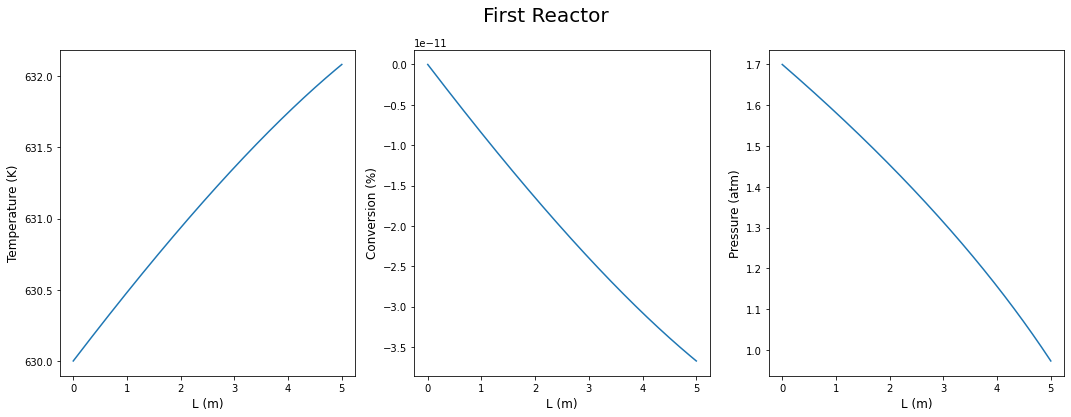

In [102]:
def ode(vec, L):
    
    T = vec[0]
    x = vec[1]
    P = vec[2]
    
    Klinha = (5.74e13 * Eb / roB) * np.exp(-38000 / (1.987 * T))
    rA = - Klinha * CA0 * (1-x) * (P0 / T0) * (P/T)
    
    
    dxdL = 2.7e-3 * rA
    dTdL = - 1.53e8 * rA
    dPdL = - 3.08e-4 * T / P
    
    return [dTdL, dxdL, dPdL]

L = np.linspace(0., 5., 1000)
vec_ode = odeint(ode, [630., 0., 1.7], L)

T_ode = vec_ode[:, 0]
x_ode = vec_ode[:, 1]
P_ode = vec_ode[:, 2]


# plot the results
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(18,6))    # creating subplot

ax[0].plot(L, T_ode)    # plotting T over L
ax[0].set_xlabel("L (m)", fontsize=12)
ax[0].set_ylabel("Temperature (K)", fontsize=12)

ax[1].plot(L, x_ode)    # plotting x over L
ax[1].set_xlabel("L (m)", fontsize=12)
ax[1].set_ylabel("Conversion (%)", fontsize=12)

ax[2].plot(L, P_ode)    # plotting P over L
ax[2].set_xlabel("L (m)", fontsize=12)
ax[2].set_ylabel("Pressure (atm)", fontsize=12)

plt.suptitle('First Reactor', fontsize=20)